In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person300_bacteria_1421.jpeg
/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person318_bacteria_1474.jpeg
/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person266_bacteria_1245.jpeg
/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person321_bacteria_1487.jpeg
/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person122_bacteria_582.jpeg
/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person300_bacteria_1422.jpeg
/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person349_bacteria_1605.jpeg
/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person267_bacteria_1252.jpeg
/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/val/BACTERIAL/person123_bacteria_587

In [3]:
path = '/kaggle/input/classification-of-covid-viral-bacterial-pneumonia/Data/'

train_path = os.path.join(path, 'train')
train_normal_path = os.path.join(train_path, 'NORMAL')
train_covid_path = os.path.join(train_path, 'COVID')
train_bacterial_path = os.path.join(train_path, 'BACTERIAL')
train_viral_path = os.path.join(train_path, 'VIRAL')

val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

In [4]:
def load_img(folder_path):
    images = []
    label = []
    for folderclass in tqdm(os.listdir(folder_path)):
        folderclass_path = os.path.join(folder_path,folderclass)
        for clas in os.listdir(folderclass_path):
            img_path = os.path.join(folder_path, folderclass)
            img_path = os.path.join(img_path, clas)
#             print(img_path)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (150, 150)) 
#                 print(img.shape)
                img = img.reshape(150, 150,3)  
                img = img.astype('float32') / 255.0  
                images.append(img)
#                 print(folderclass)
                label.append(folderclass)
            except Exception as e:
                print(str(e))
    return np.array(images), label

In [5]:
train = load_img(os.path.join(path, 'train'))
val = load_img(os.path.join(path, 'val'))

100%|██████████| 4/4 [00:19<00:00,  4.90s/it]


In [6]:
X_train, y_train = train
X_train.shape

(4512, 150, 150, 3)

In [7]:
X_train, y_train = train
X_val, y_val = val

In [8]:
# ubah value label dari string menjadi angka
# misal: 'normal' menjadi 0
le = LabelEncoder()
le.fit(y_train)

y_train2 = le.transform(y_train)
y_val2 = le.transform(y_val)

# Baseline (Tanpa Feature Extraction VGG16)

In [9]:
X_train_bsl = X_train.reshape((4512, 67500))
X_val_bsl = X_val.reshape((966, 67500))

In [10]:
dftrainbsl = pd.DataFrame(X_train_bsl)
dfvalbsl = pd.DataFrame(X_val_bsl)

In [11]:
svm_bsl = SVC()
svm_bsl.fit(dftrainbsl, y_train2)

print(f1_score(y_val2, svm_bsl.predict(dfvalbsl), average='macro'))

0.7627246162181801


# Menggunakan Feature Extraction VGG16

## Membangun Pretrained Model VGG16

In [12]:
# mengaplikasikan pretrained model VGG16
vgg = VGG16(weights='imagenet', # menggunakan weight pretraine yang disediakan dataset ImageNet.
            include_top=False, # tanpa menyertakan fully-connected layer  
            input_shape=(150, 150, 3) # input data
           )

# pada tiap layer, freeze layer sehingga bobot dan bias dari lapisan tersebut tetap tidak berubah.
for layer in vgg.layers:
    layer.trainable = False

In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
# ambil block4_conv3 (Conv2D)
vgg.layers[-6]

## Ekstraksi Fitur Citra dengan VGG16

### Show feature map visualization from feature extraction using VGG16

In [15]:
def visual_last_output_feature_map():
    """
    memvisualisasikan feature map dari lapisan terakhir model VGG16. 
    Fitur map ini dihasilkan menggunakan gambar input yang dipilih secara acak
    """
    
    # pick up to 6 last layer (block4_conv3 (Conv2D))
    last_layer_output = vgg.layers[-6].output

    # Create a new model that takes the input of the original VGG16 model and outputs the last layer output
    feature_map_model = tf.keras.models.Model(inputs=vgg.input, 
                                              outputs=last_layer_output
                                             )

    # Generate random input image
    input_image = X_train[2:3,:,:,:]

    # Get the feature map from the input image
    feature_map = feature_map_model.predict(input_image)

    # Get the number of feature maps
    num_feature_maps = feature_map.shape[-1]

    # Create a grid for visualizing the feature maps
    grid_size = int(np.ceil(np.sqrt(num_feature_maps)))

    # Visualize the feature maps
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        if i < num_feature_maps:
            ax.imshow(feature_map[0, :, :, i], cmap='gray')
            if i == 10:
                ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

1/1 [==============================] - 2s 2s/step


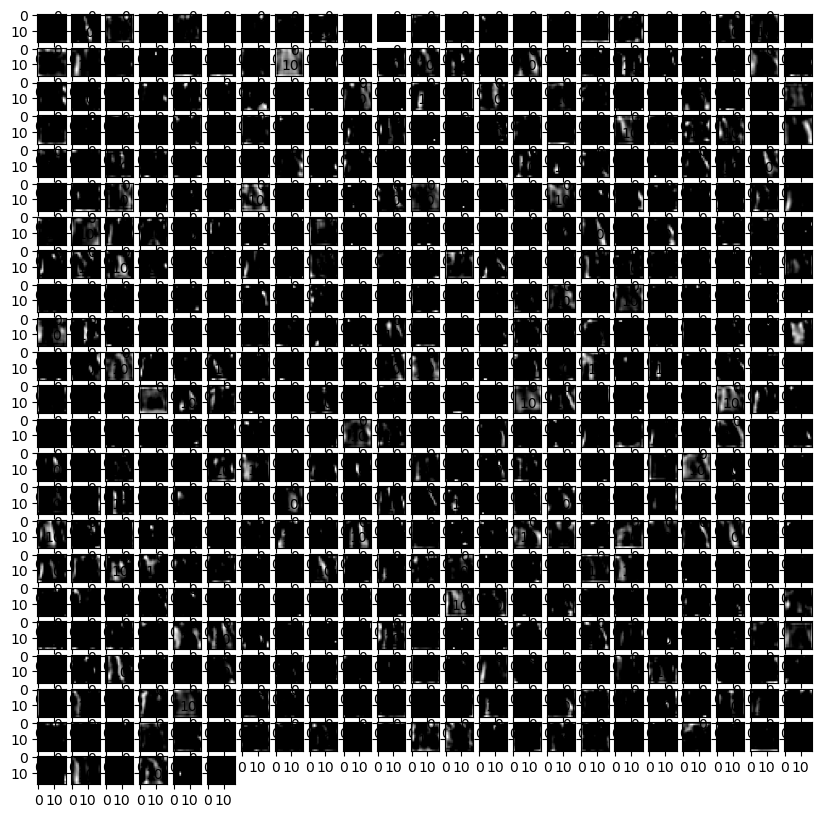

In [16]:
visual_last_output_feature_map()

In [17]:
def visual_feature_map(path, n_filter=10):
    """
     memvisualisasikan seluruh feature map dari setiap lapisan dalam model VGG16. Fitur map ini 
     dihasilkan menggunakan gambar input yang diambil dari path file gambar tertentu.
    """
    
    successive_outputs = [layer.output for layer in vgg.layers[1:]]
    visualization_model = tf.keras.models.Model(inputs = vgg.input, outputs = successive_outputs)        
    image_path = path
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150, 3))
    input_image = tf.keras.preprocessing.image.img_to_array(image)
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.keras.applications.vgg16.preprocess_input(input_image)

    successive_feature_maps = visualization_model.predict(input_image)
    layer_names = [layer.name for layer in vgg.layers]
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#       print(feature_map.shape)
      if len(feature_map.shape) == 4:
        n_features = n_filter 
        size       = feature_map.shape[ 1]  

        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            if i < 10:
                x  = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std ()
                x *=  64
                x += 128
                x  = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='gray' )

1/1 [==============================] - 0s 199ms/step


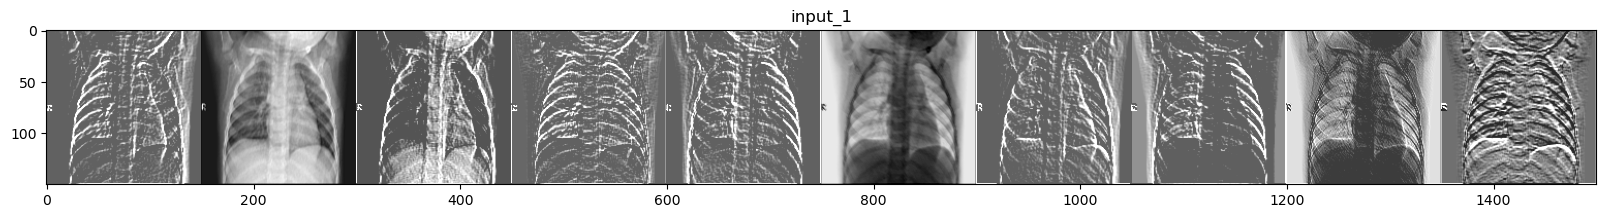

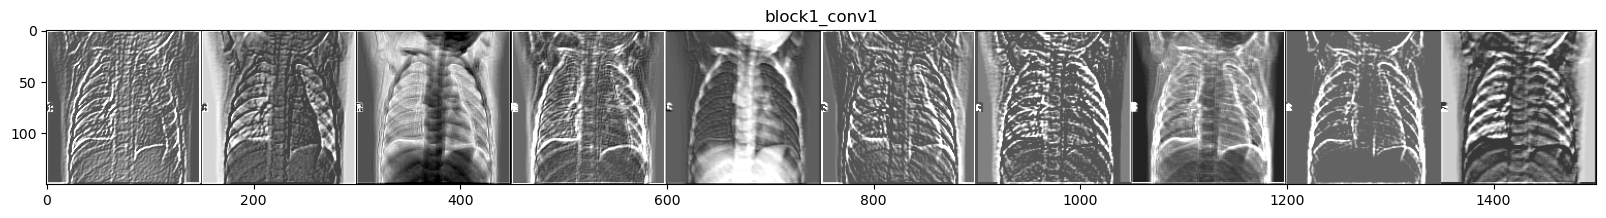

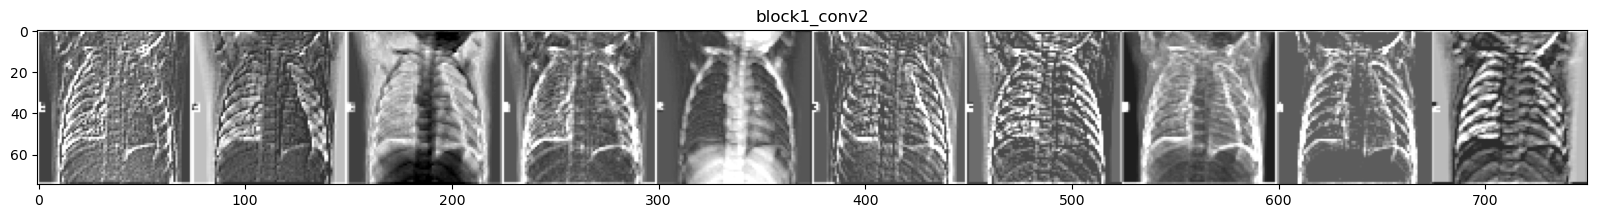

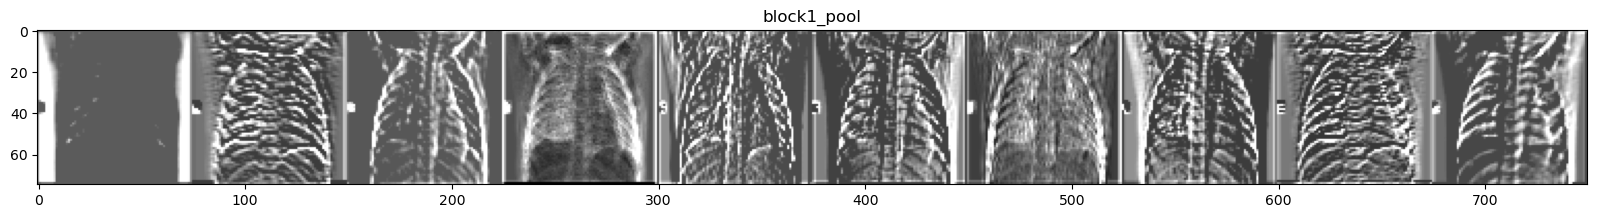

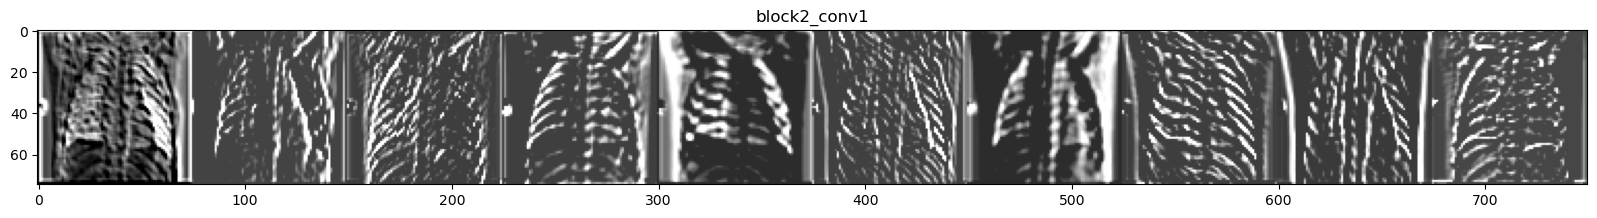

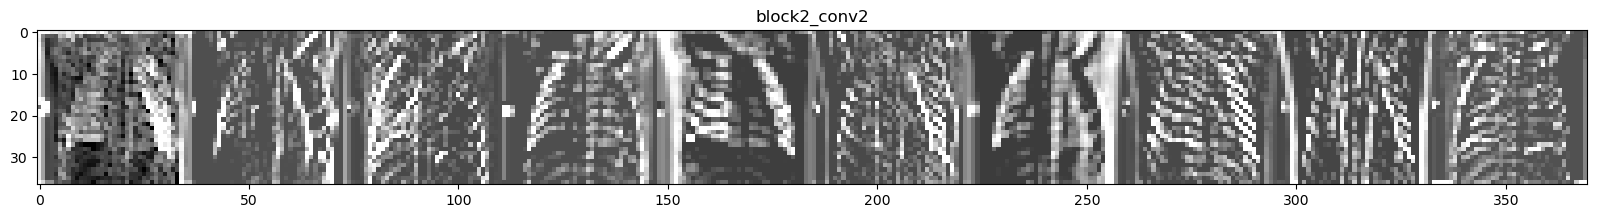

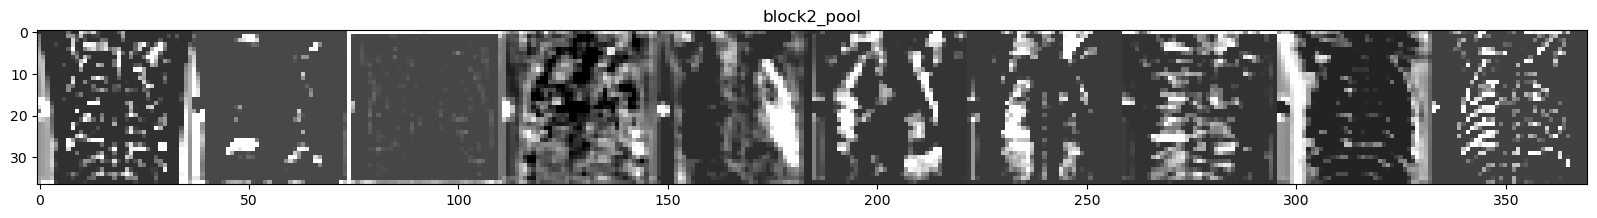

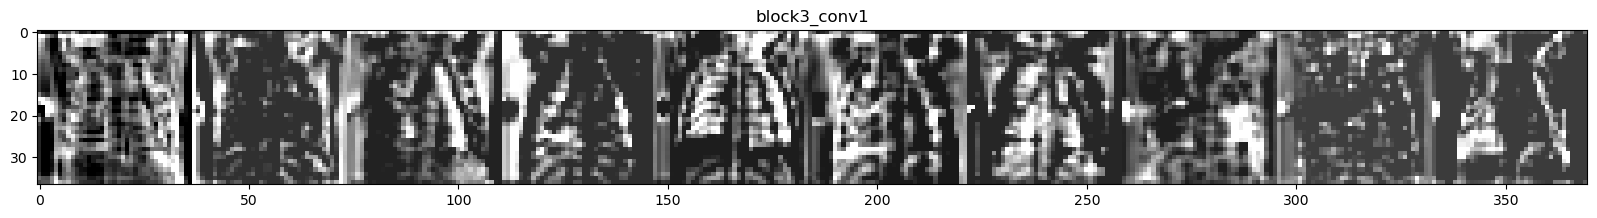

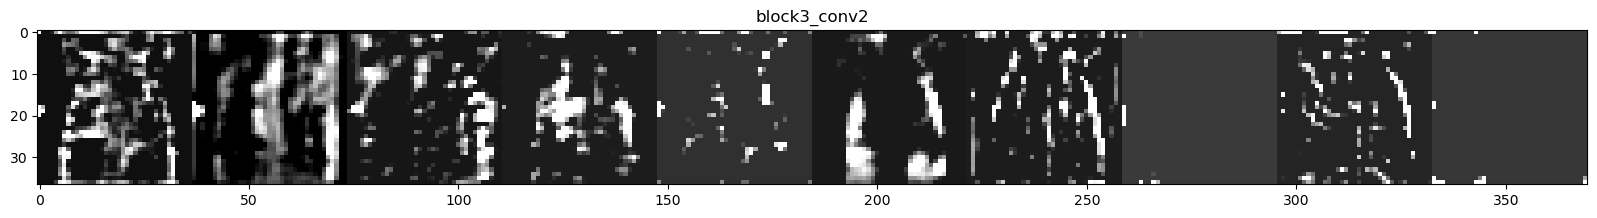

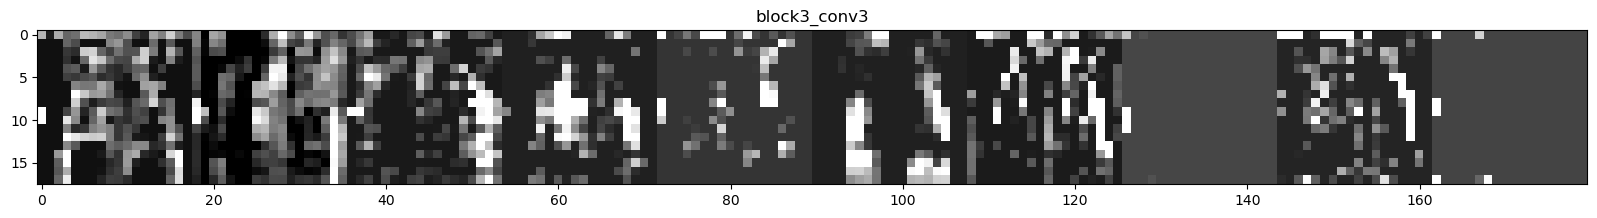

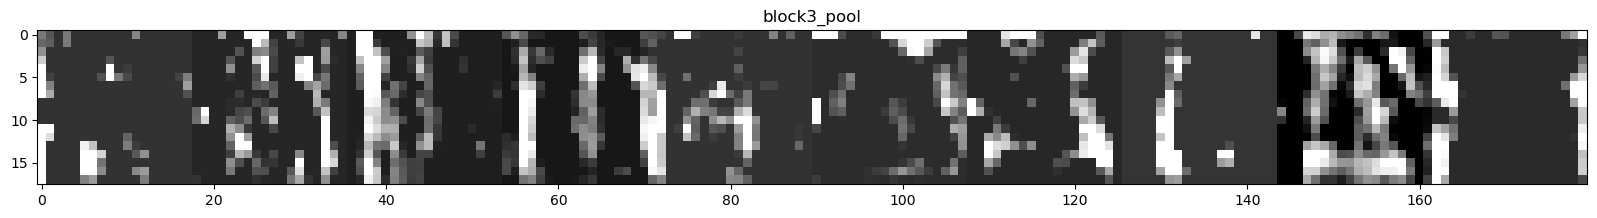

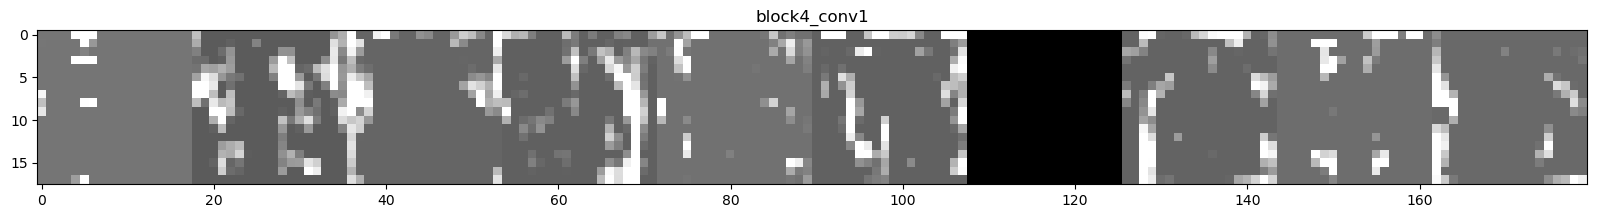

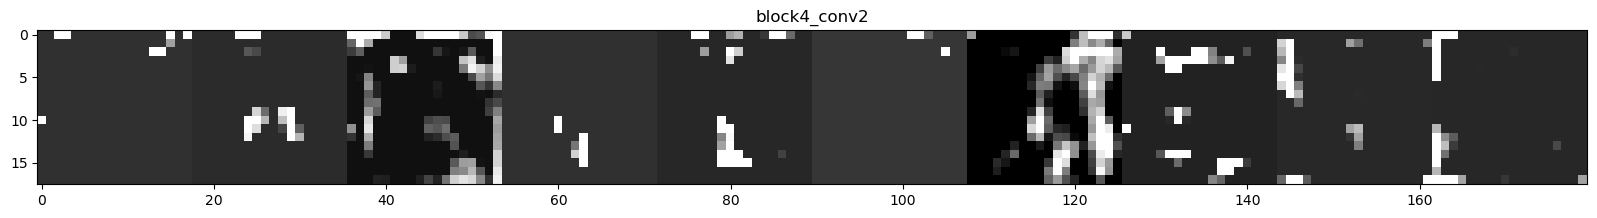

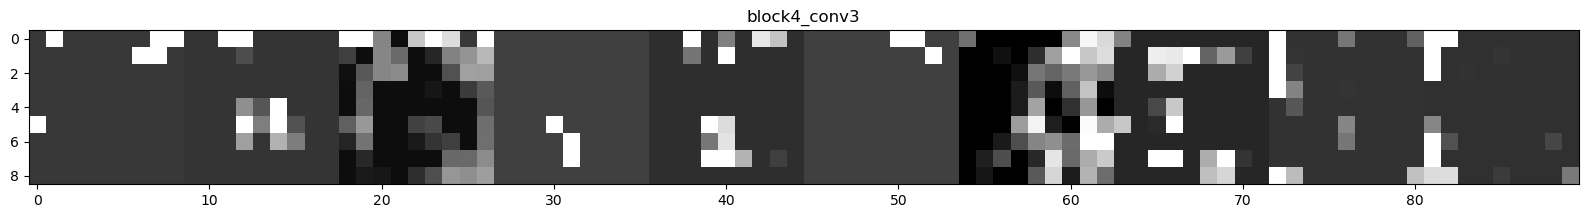

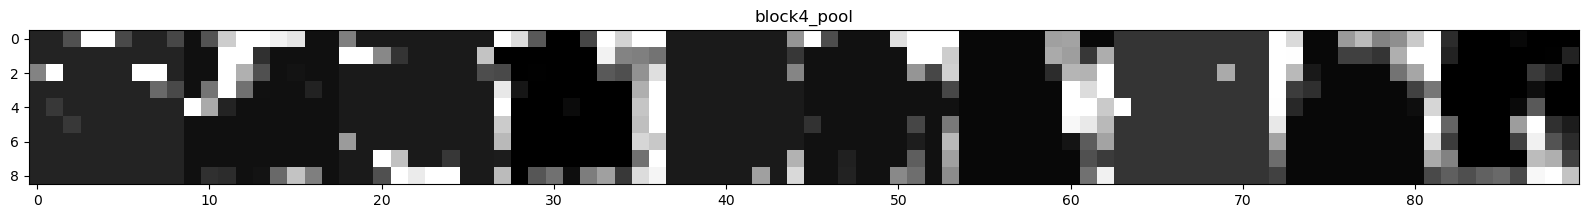

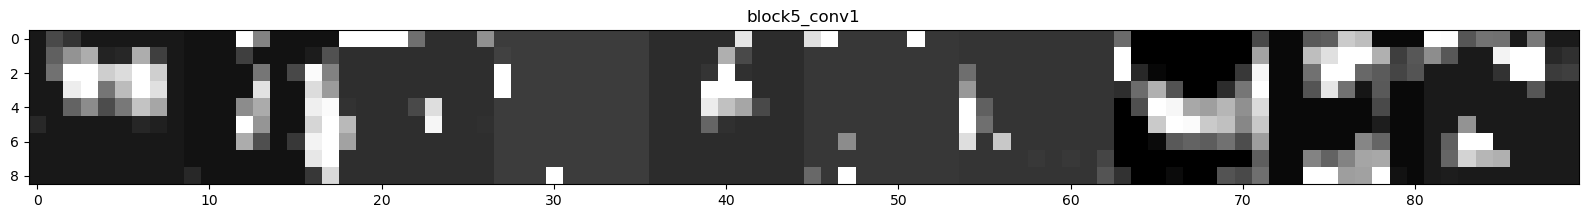

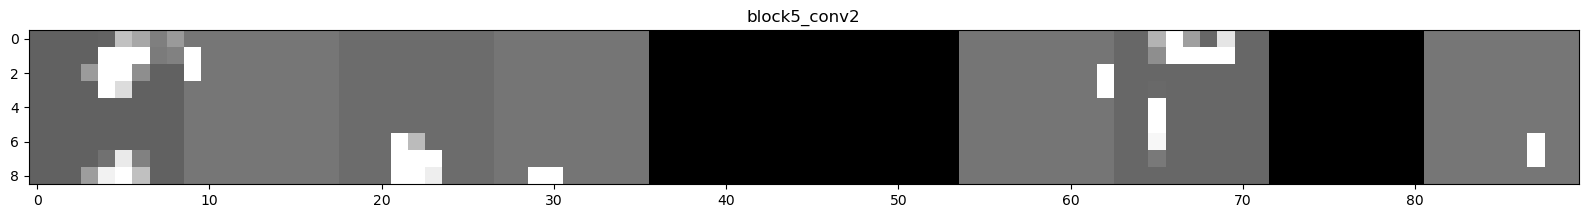

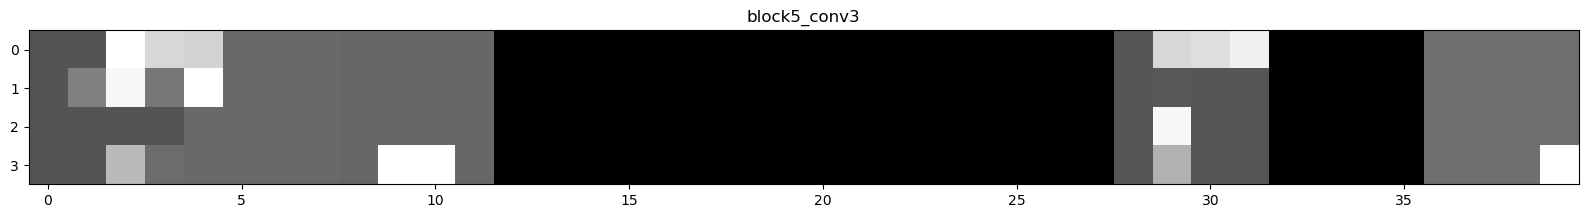

In [18]:
# visualisasi feature map paru-paru normal
visual_feature_map(os.path.join(train_normal_path, 'NORMAL2-IM-1091-0001.jpeg'))

1/1 [==============================] - 0s 147ms/step


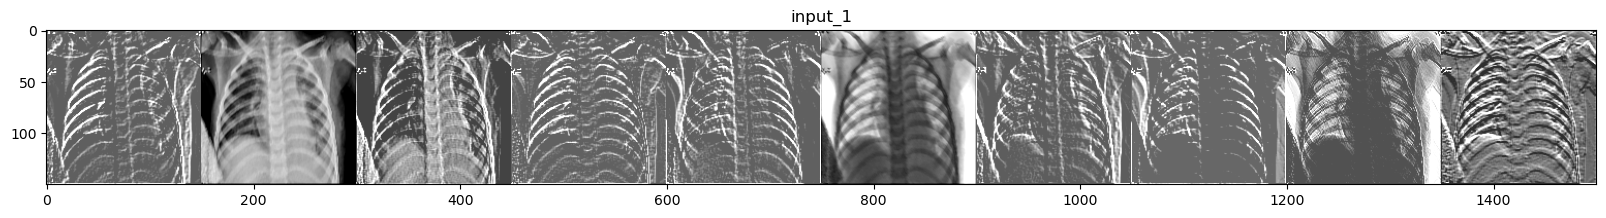

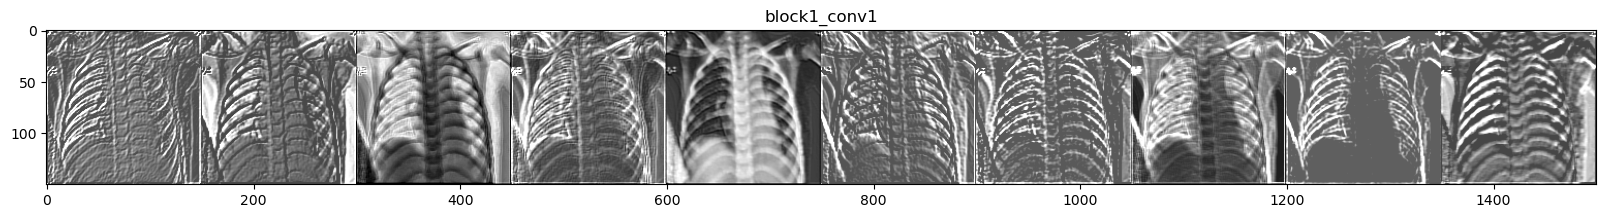

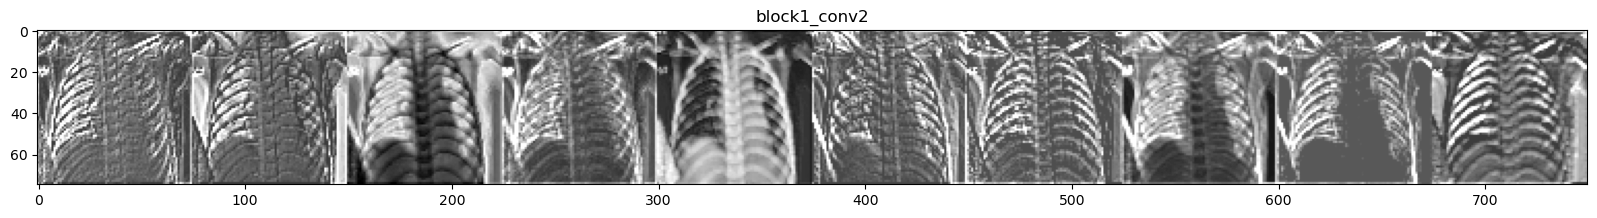

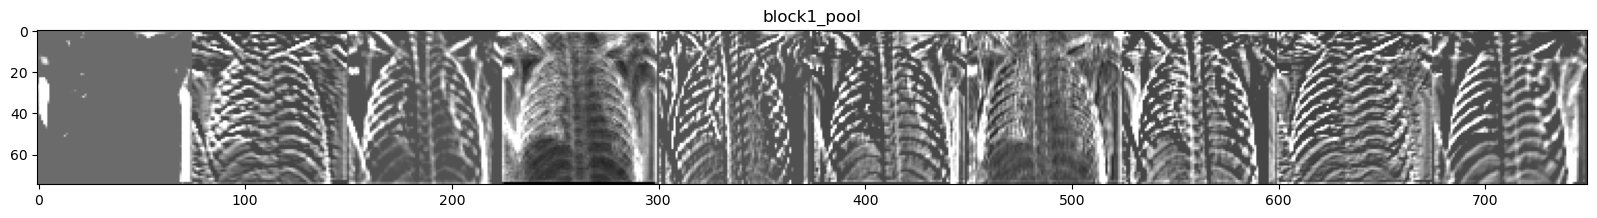

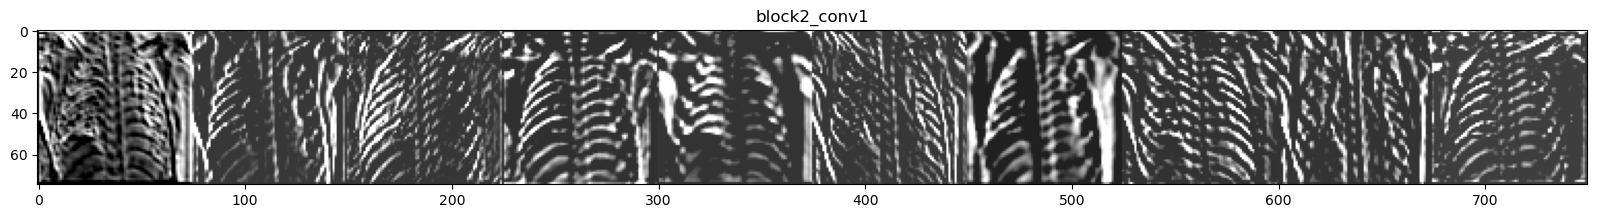

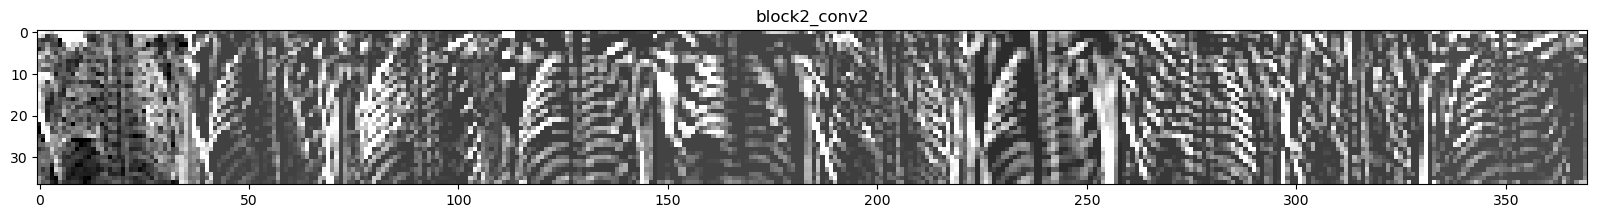

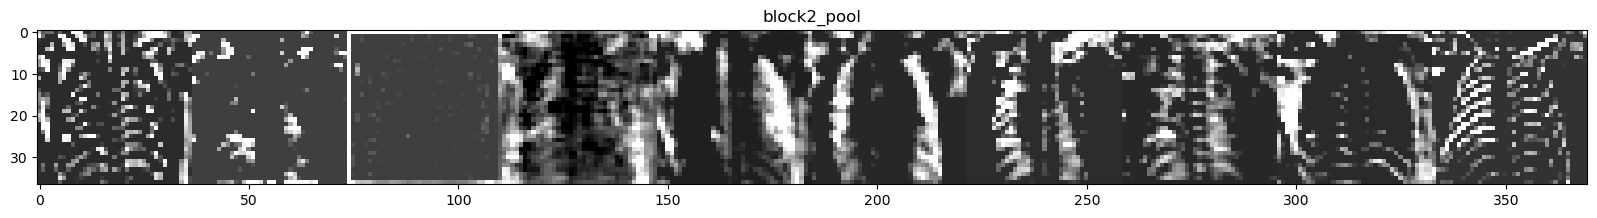

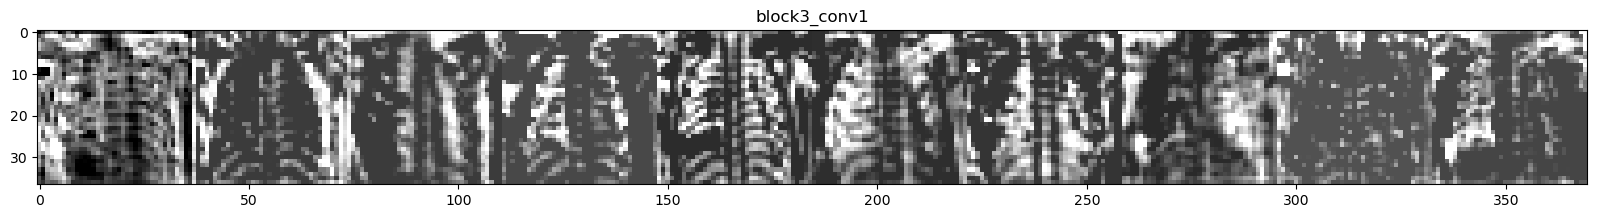

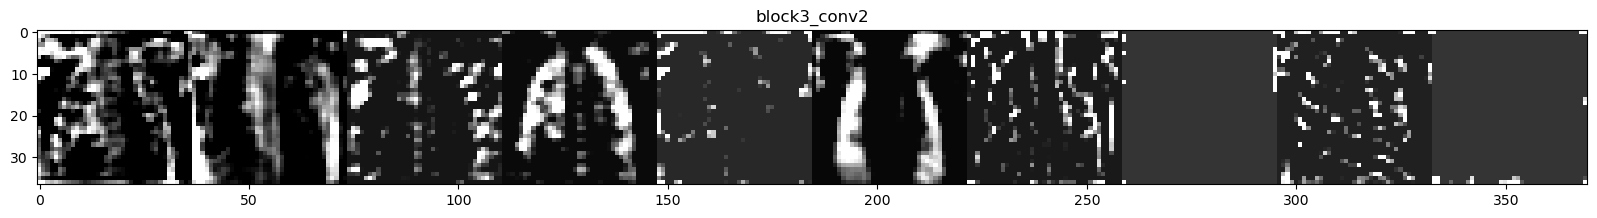

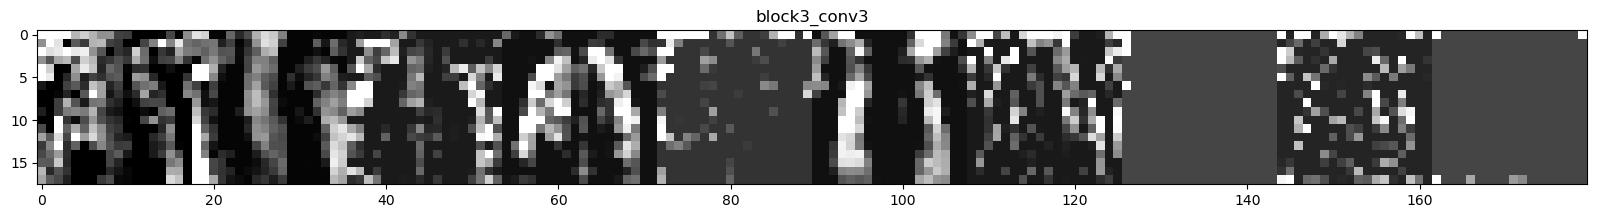

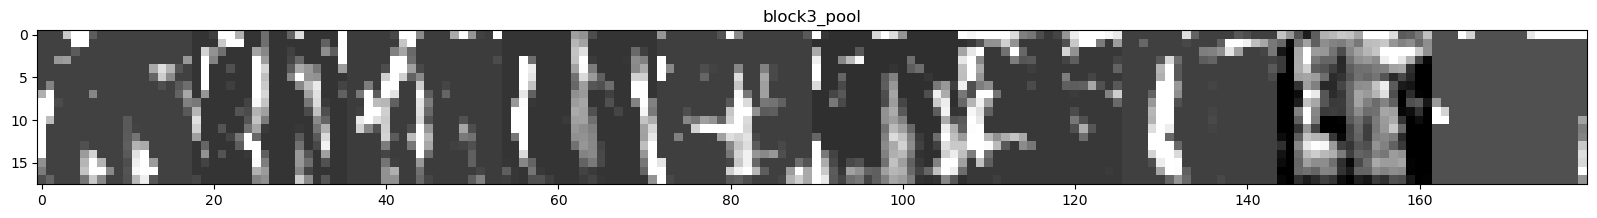

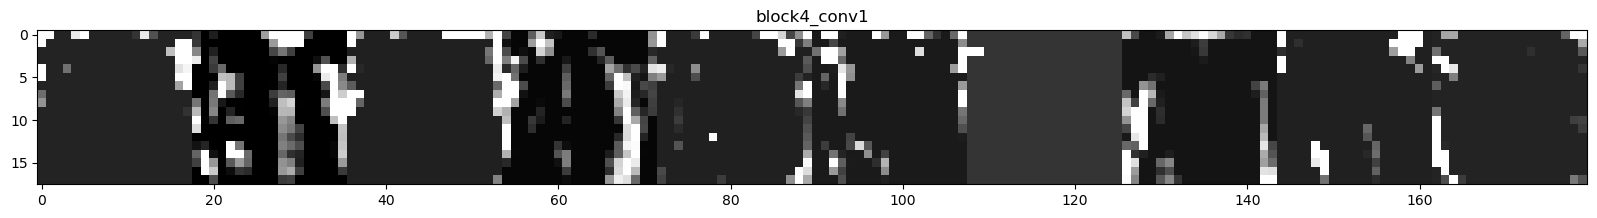

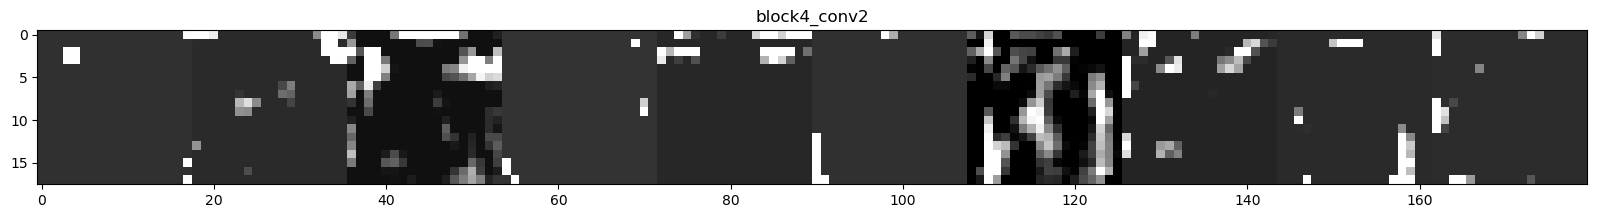

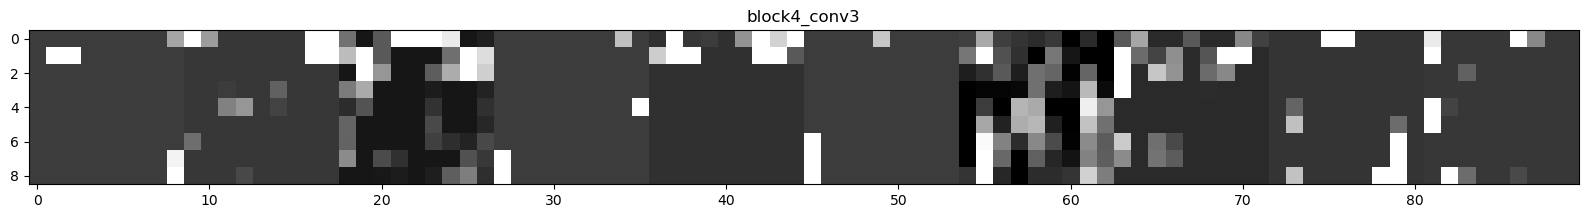

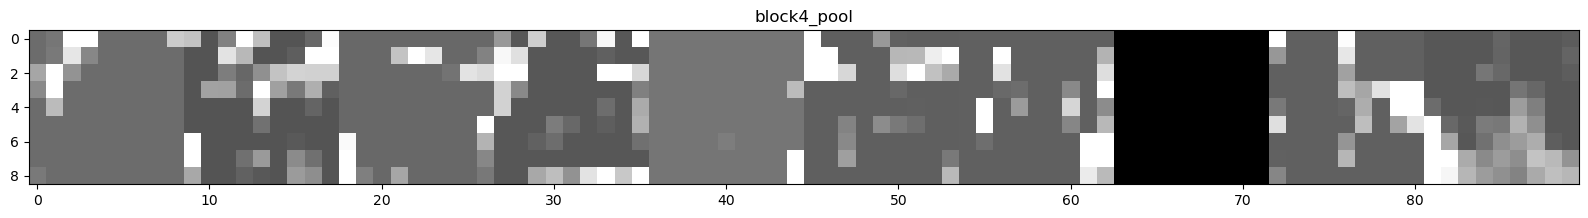

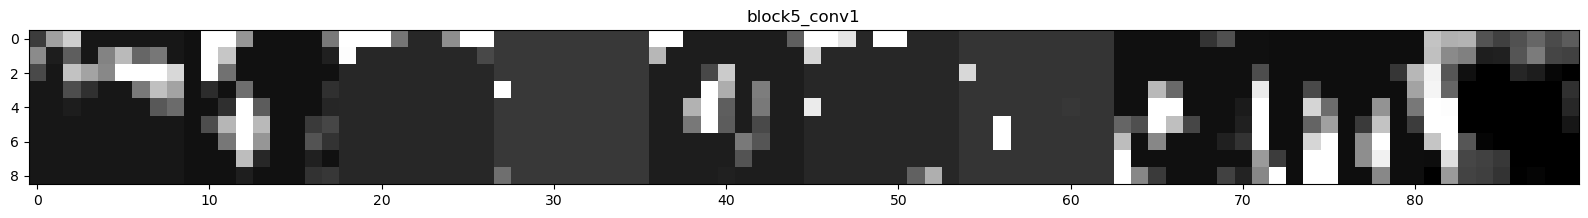

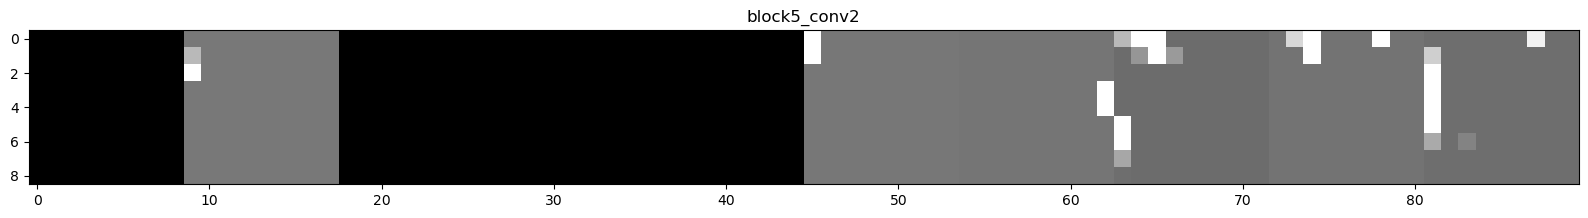

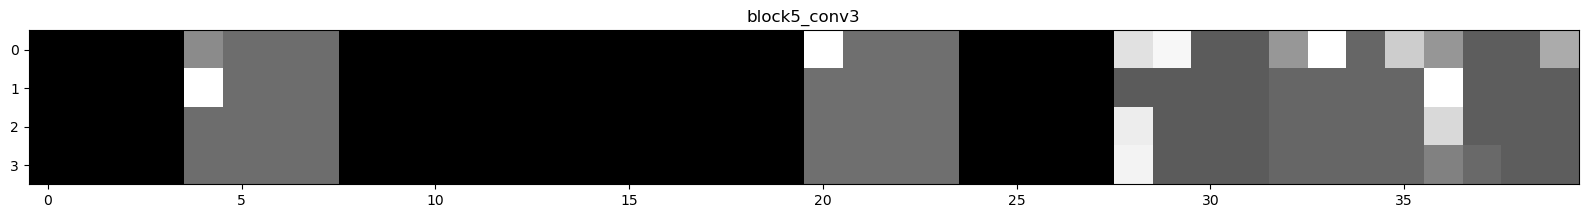

In [19]:
# visualisasi feature map paru-paru pneunomia akibat bakteri
visual_feature_map(os.path.join(train_bacterial_path, 'person1449_bacteria_3746.jpeg'))

1/1 [==============================] - 0s 149ms/step


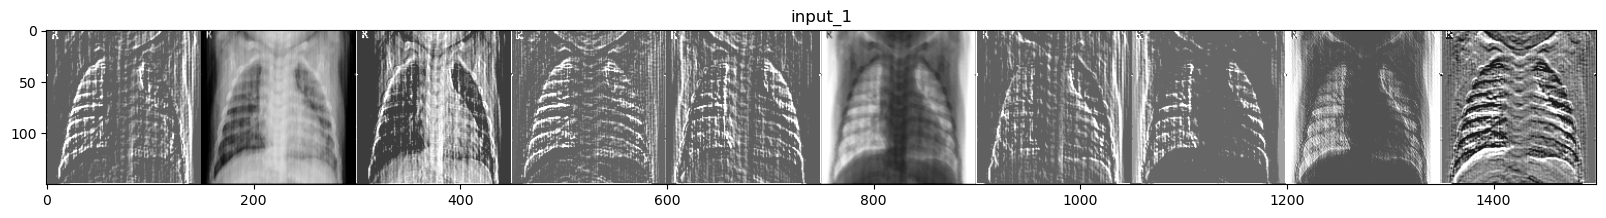

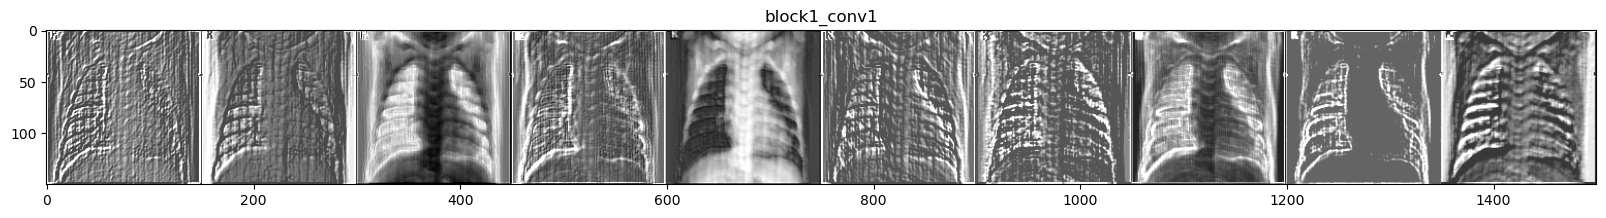

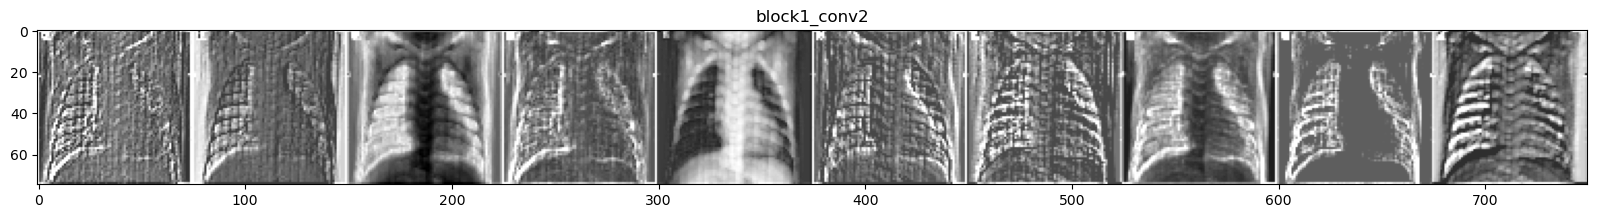

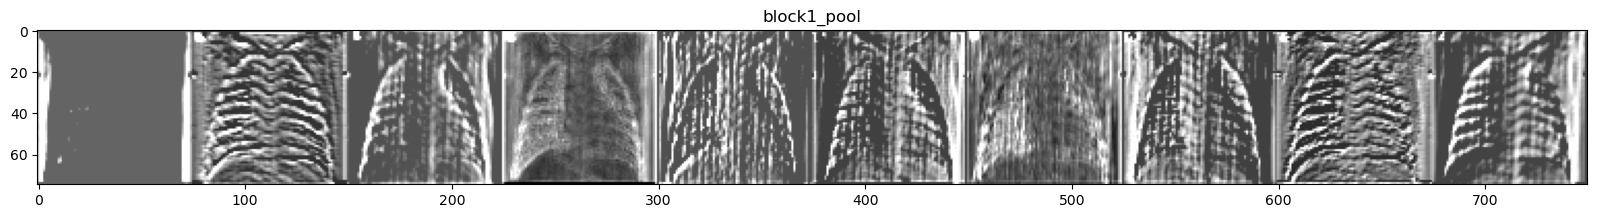

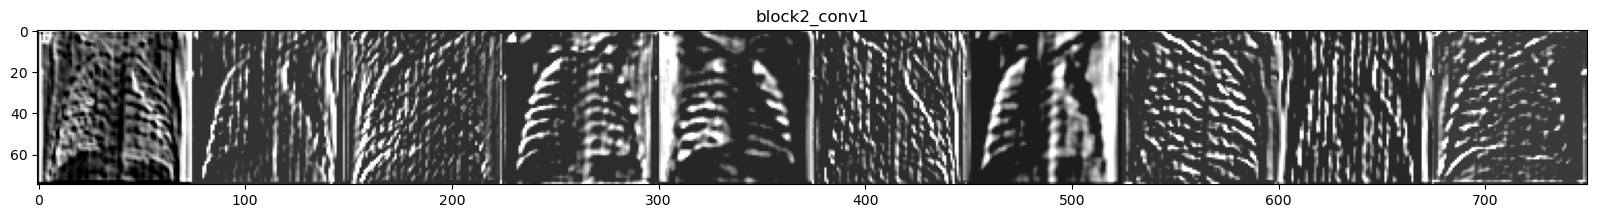

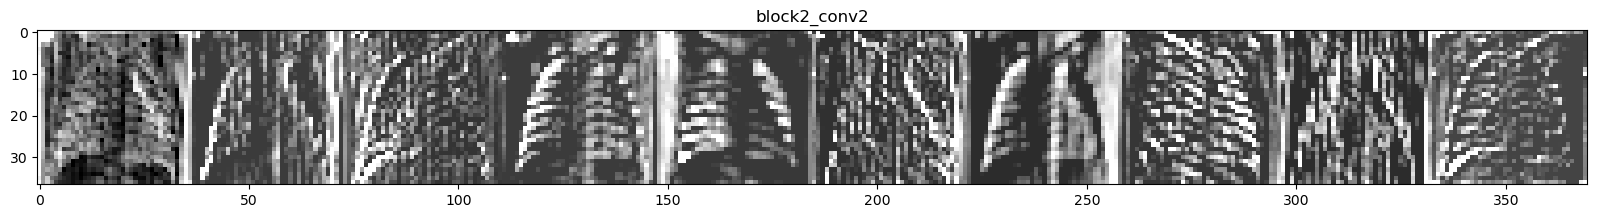

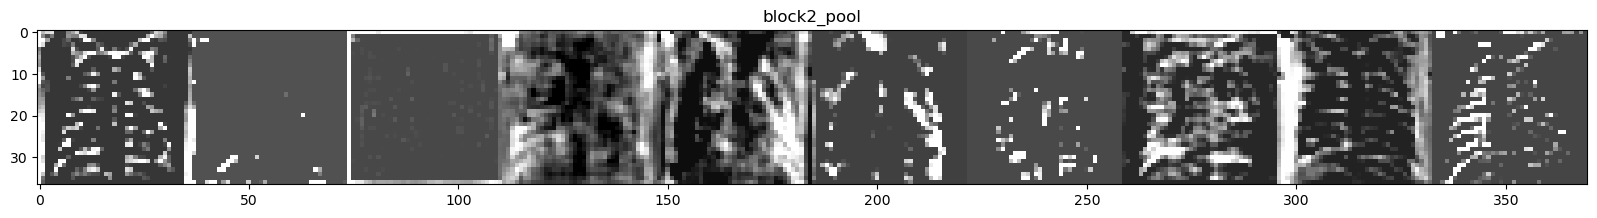

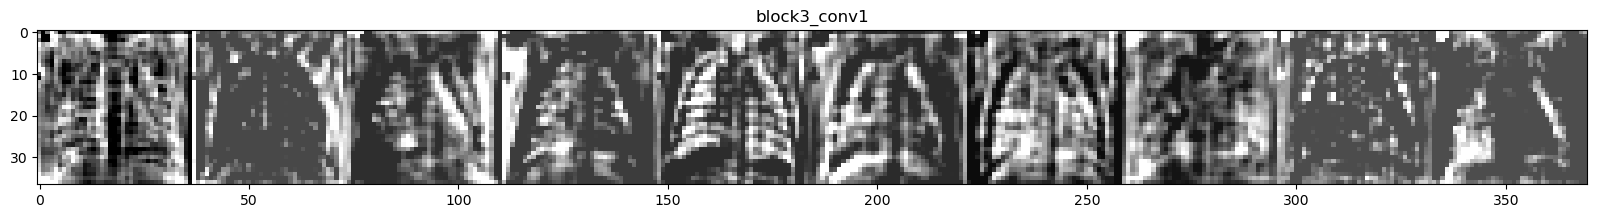

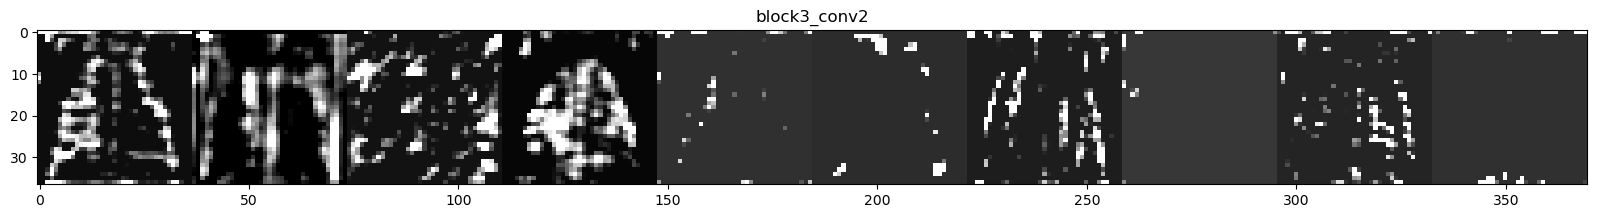

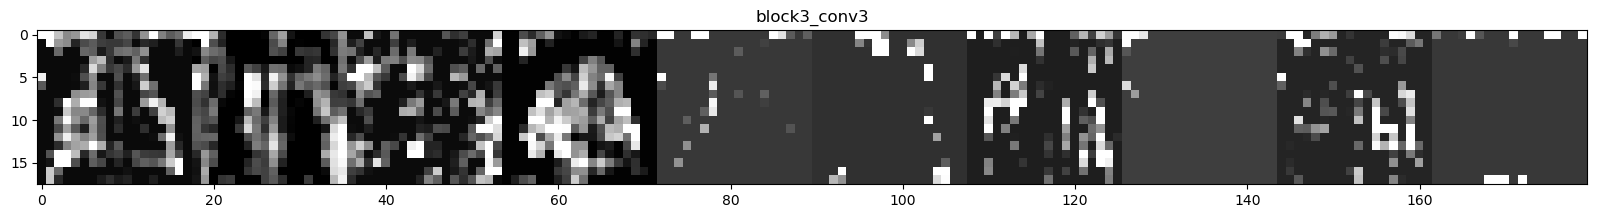

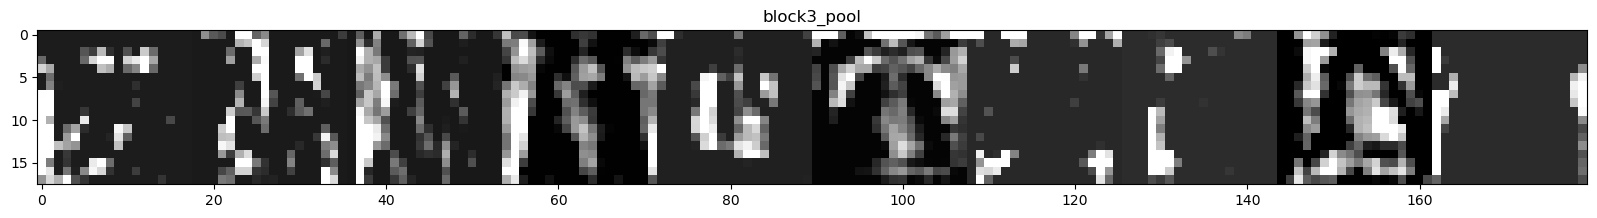

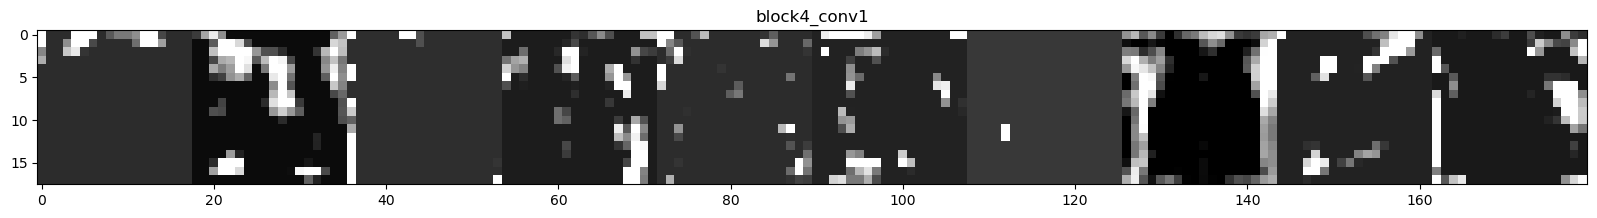

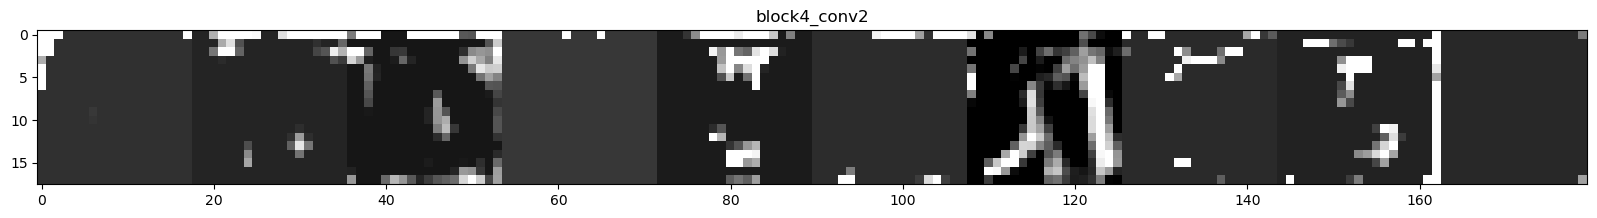

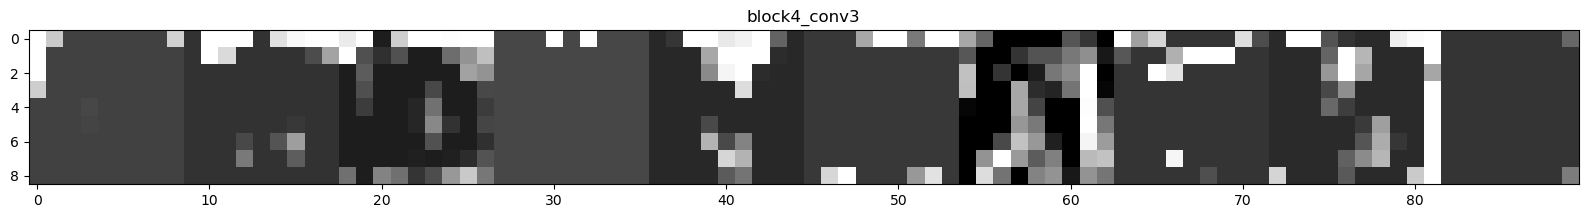

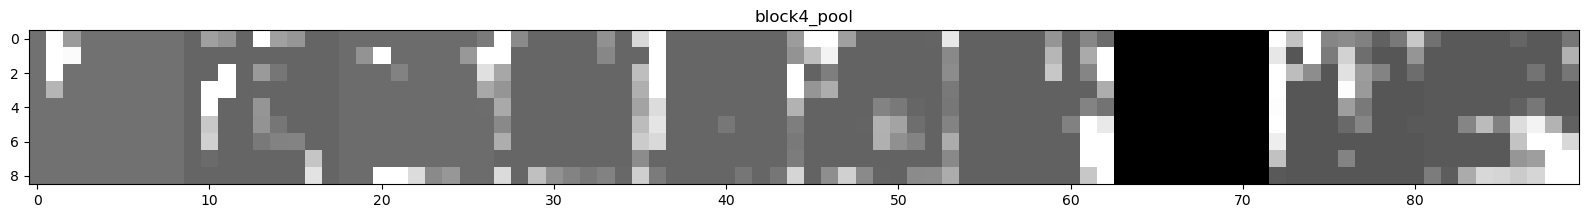

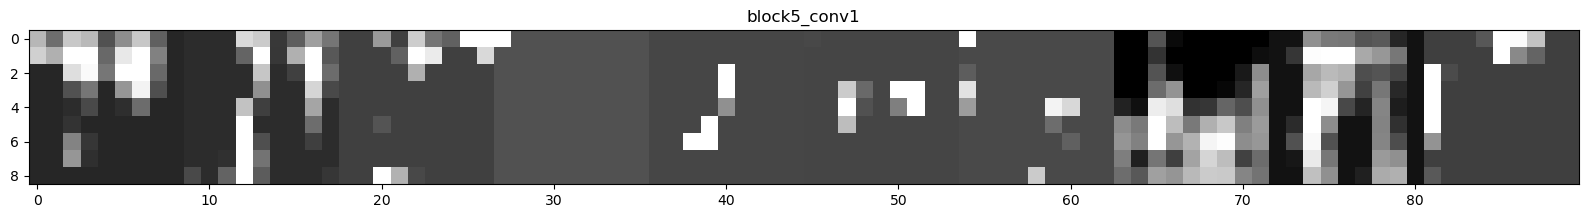

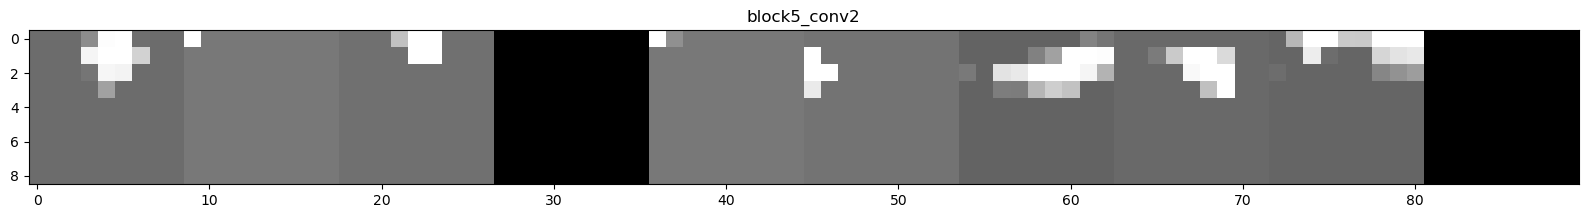

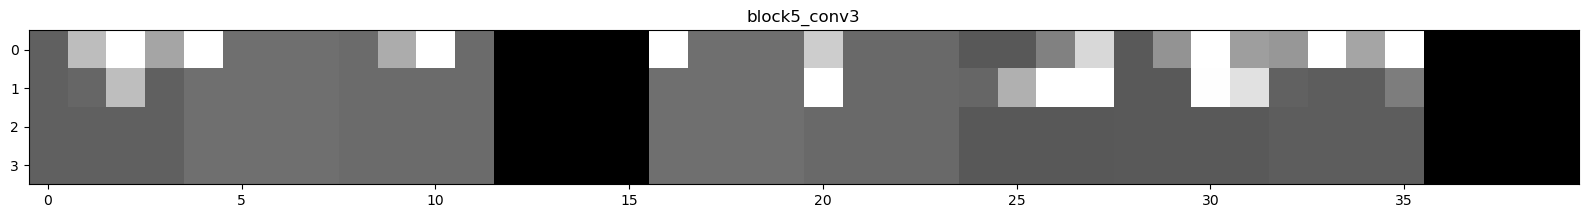

In [20]:
# visualisasi feature map paru-paru pneunomia akibat virus
visual_feature_map(os.path.join(train_viral_path, 'person1556_virus_2699.jpeg'))

1/1 [==============================] - 0s 150ms/step


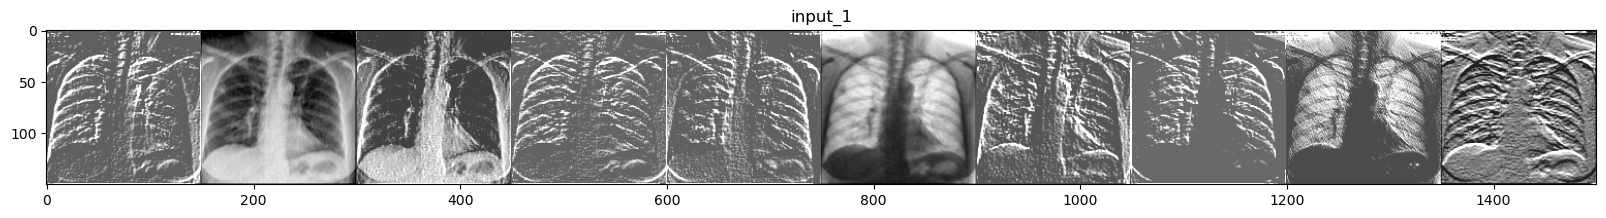

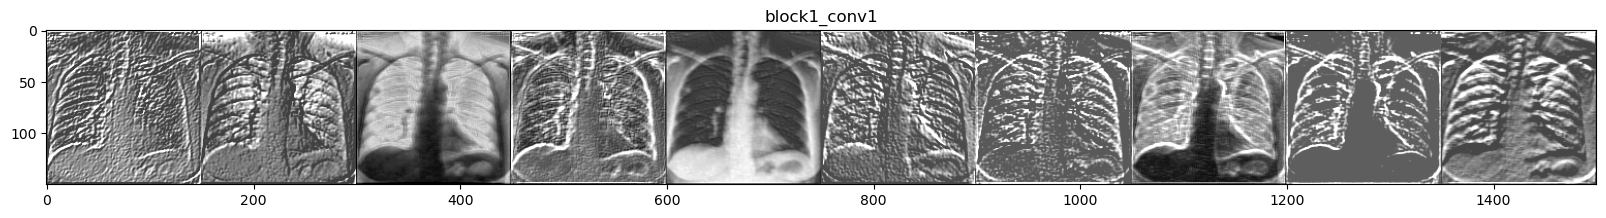

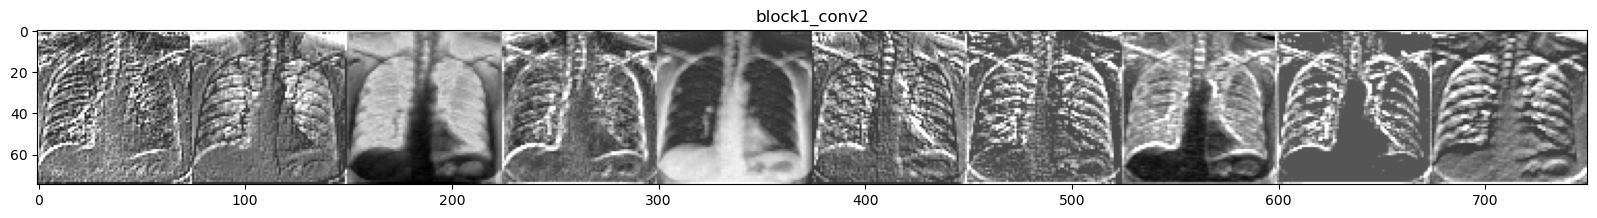

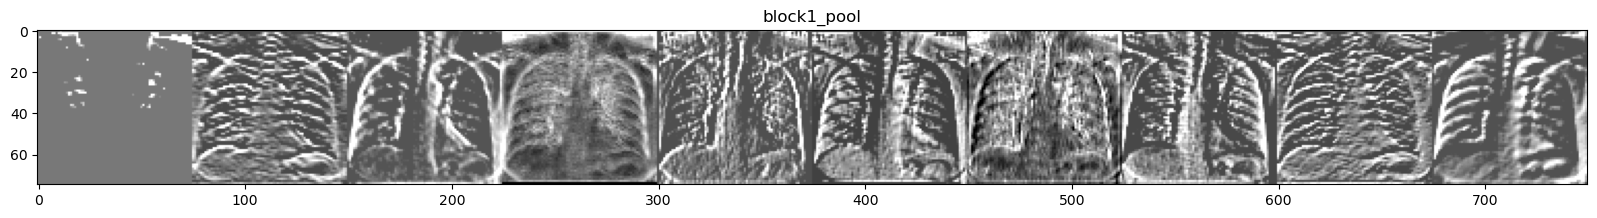

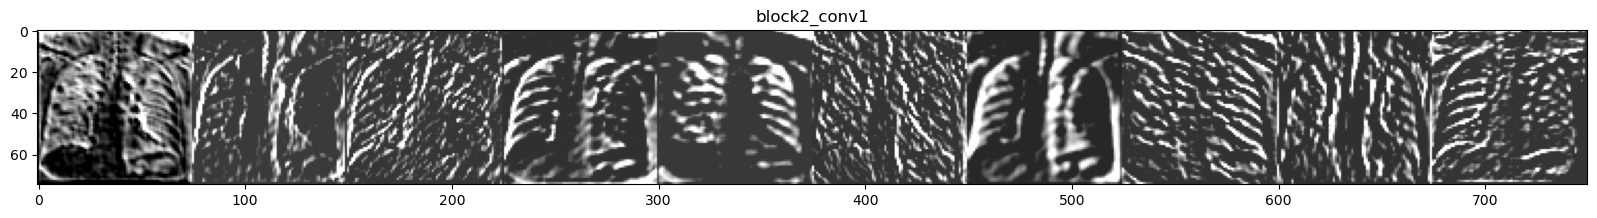

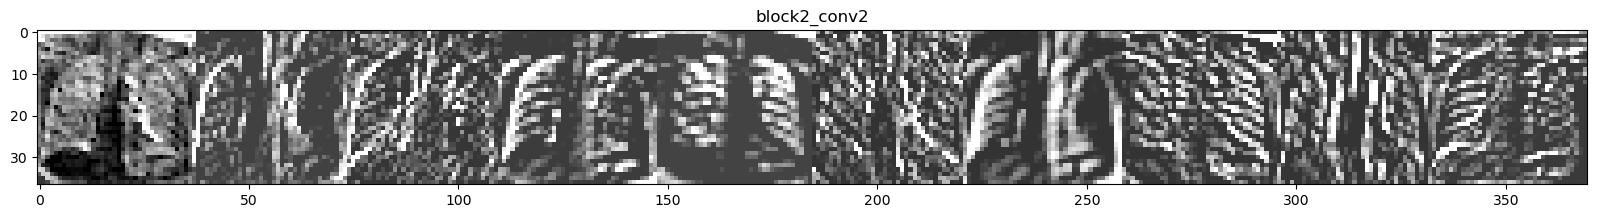

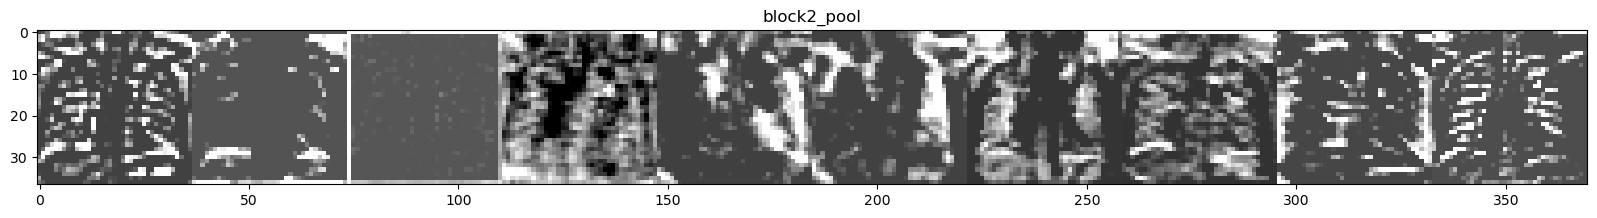

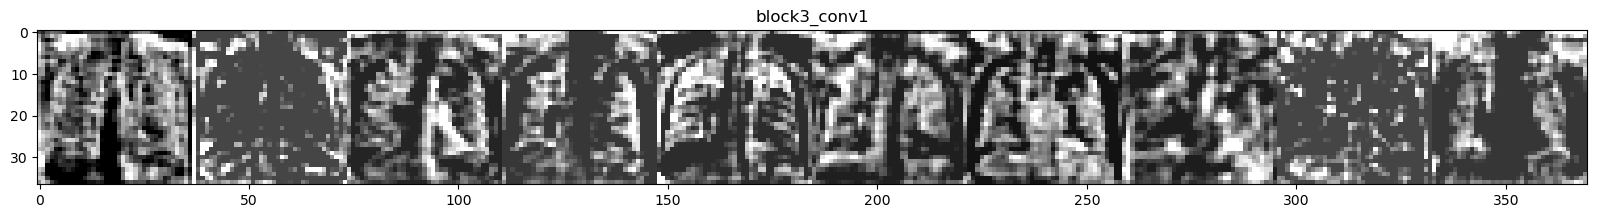

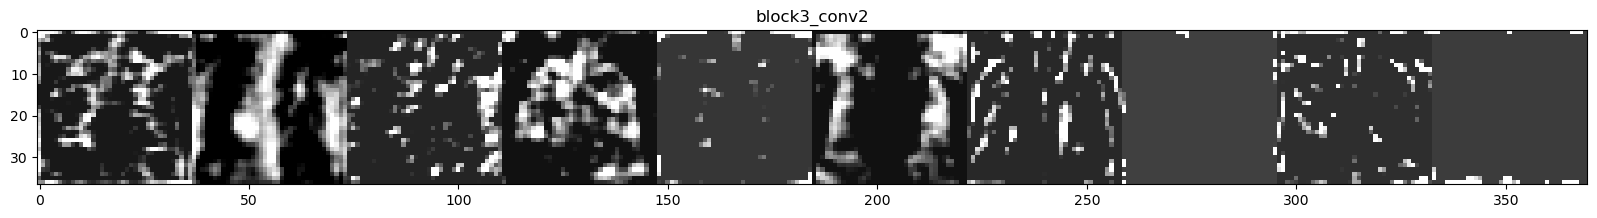

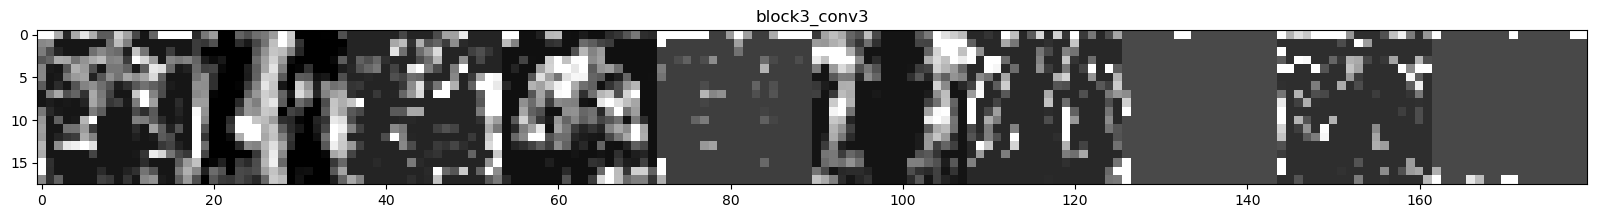

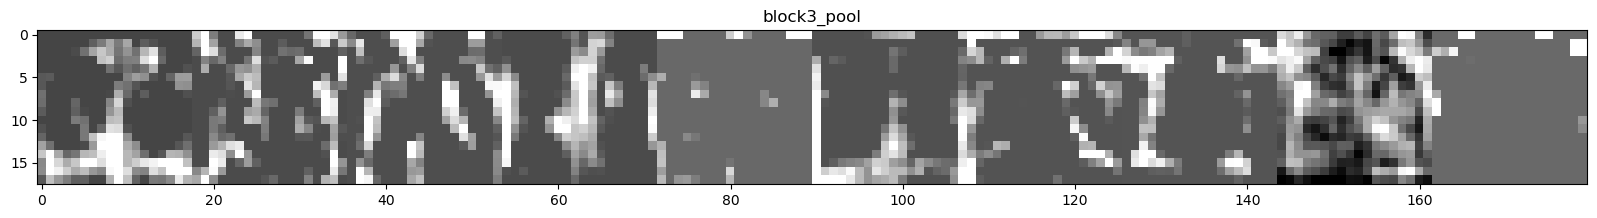

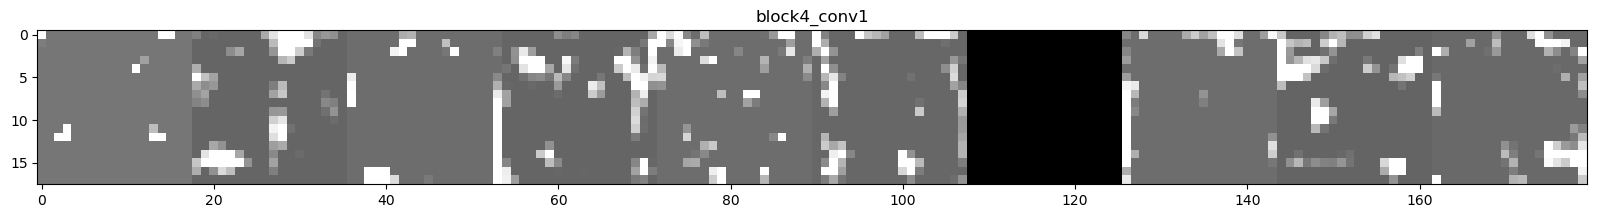

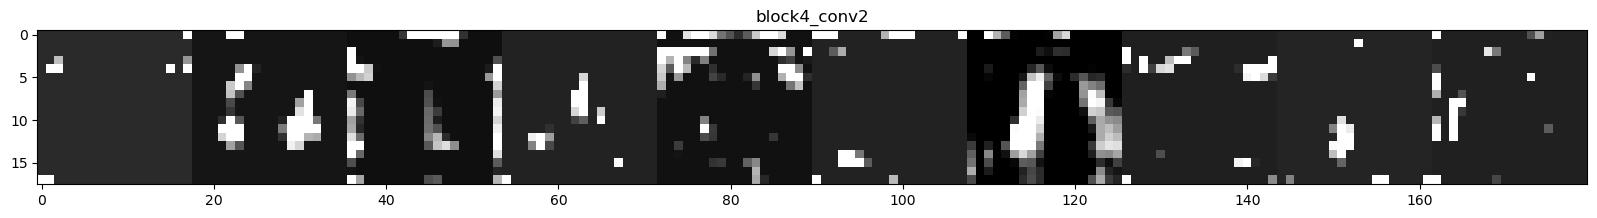

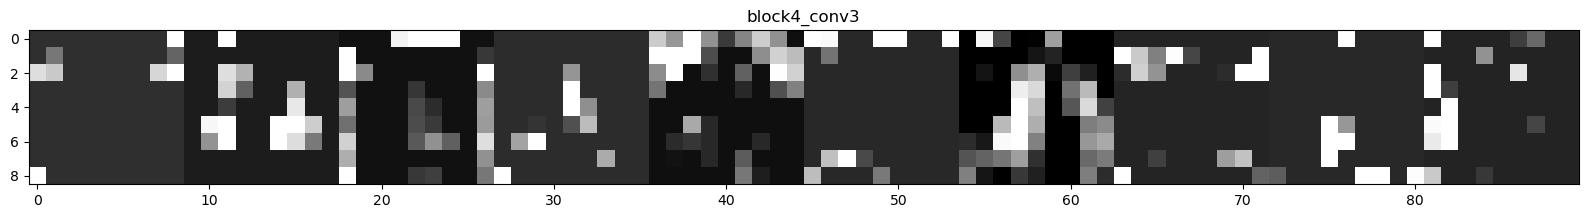

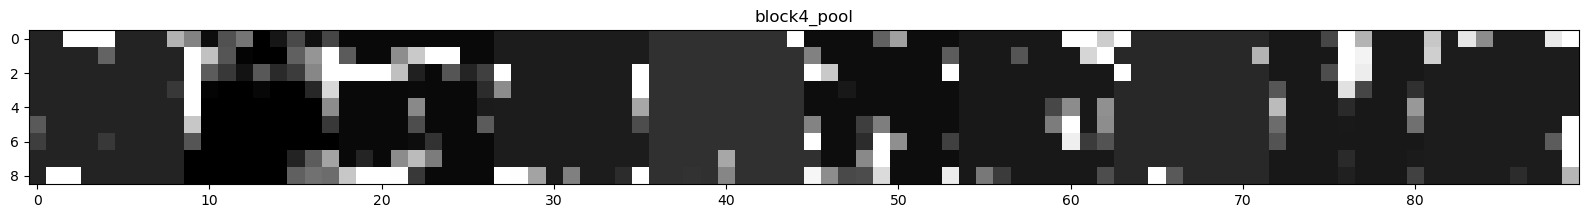

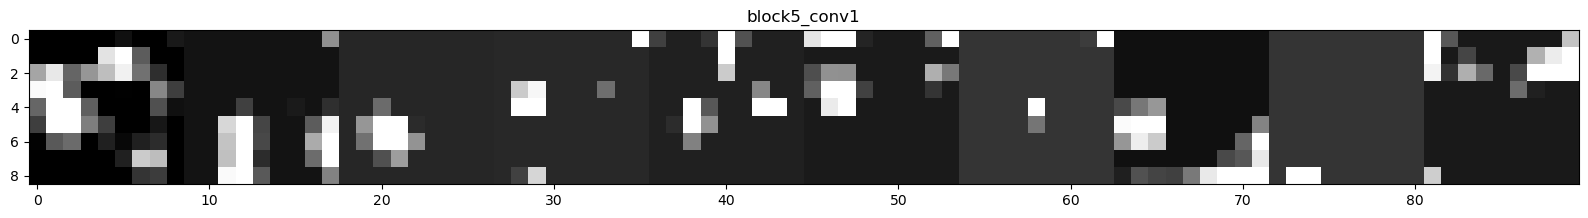

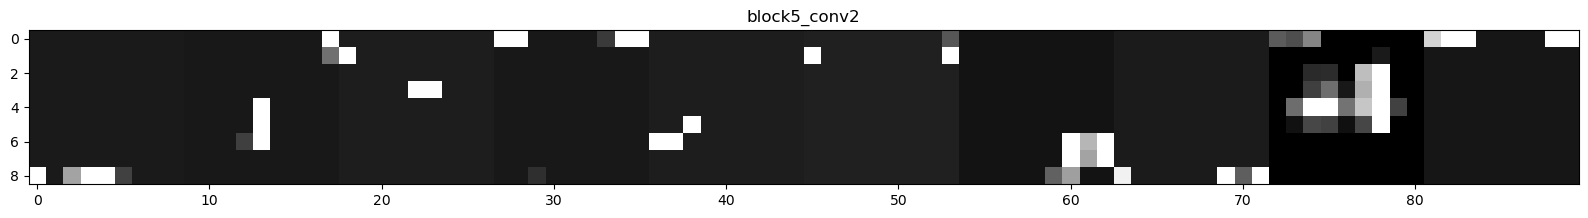

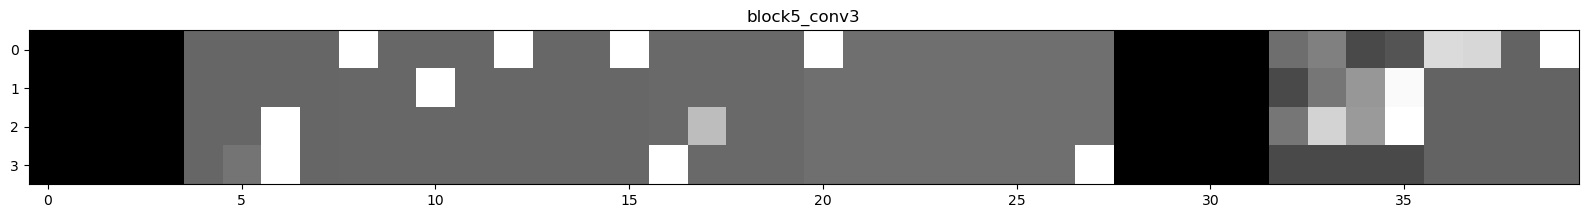

In [21]:
# visualisasi feature map paru-paru pneunomia akibat covid
visual_feature_map(os.path.join(train_covid_path, 'COVID19(338).jpg'))

In [22]:
X_train, y_train = train
X_val, y_val = val

In [23]:
# dapatkan hasil ekstraksi fitur train dari VGG dan konvert ke list
img_cnn_train = []
for idx, row in enumerate(X_train):
    hasil_cnn = vgg.predict(row.reshape(1,150,150,3))
    img_cnn_train.append(list(hasil_cnn.flatten()))

1/1 [==============================] - 0s 18ms/step


In [24]:
# dapatkan ekstraksi fitur data val dan jadikan list
img_cnn_val = []
for idx, row in enumerate(X_val):
    hasil_cnn = vgg.predict(row.reshape(1,150,150,3))
    img_cnn_val.append(list(hasil_cnn.flatten()))

1/1 [==============================] - 0s 18ms/step


In [25]:
# ubah hasil ekstraksi fitur menjadi dataframe
df_train = pd.DataFrame(img_cnn_train)
df_val = pd.DataFrame(img_cnn_val)

In [26]:
df_train

0     1         2         3         4         5         6     \
0     0.000000   0.0  0.000000  0.000000  0.743952  0.000000  0.000000   
1     0.438881   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2     0.000000   0.0  0.128312  0.000000  0.180392  0.000000  0.000000   
3     0.096491   0.0  0.000000  0.000000  0.017949  0.000000  0.000000   
4     0.188523   0.0  0.000000  0.000000  0.000000  0.000000  0.233029   
...        ...   ...       ...       ...       ...       ...       ...   
4507  0.240913   0.0  0.350842  0.000000  0.062646  0.172559  0.000000   
4508  0.627325   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4509  0.340066   0.0  0.003436  0.000000  0.000000  0.000000  0.000000   
4510  0.527260   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4511  0.000000   0.0  0.000000  0.125542  0.000000  0.000000  0.000000   

          7     8         9     ...      8182      8183      8184      8185  \
0     0.000000   0.0  0.000000  ...  1.528177  0.470595  0.458692  0.171534   
1     0.000000   0.0  0.000000  ...  1.538422  0.588136  0.552154  0.000000   
2     0.000000   0.0  0.000000  ...  0.901386  0.390865  0.763518  0.000000   
3     0.000000   0.0  0.000000  ...  1.381584  0.685908  0.725699  0.000000   
4     0.000000   0.0  0.000000  ...  0.764629  0.721068  1.180680  0.000000   
...        ...   ...       ...  ...       ...       ...       ...       ...   
4507  0.330547   0.0  0.000000  ...  1.786945  0.339403  0.601764  0.008861   
4508  0.040649   0.0  0.000000  ...  1.253450  0.362530  0.480595  0.000000   
4509  0.000000   0.0  0.000000  ...  1.499418  0.000000  0.545629  0.000000   
4510  0.000000   0.0  0.011236  ...  1.353793  0.159808  0.797095  0.000000   
4511  0.000000   0.0  0.000000  ...  1.314484  0.263101  0.160596  0.000000   

      8186      8187  8188  8189      8190  8191  
0      0.0  0.386573   0.0   0.0  0.597912   0.0  
1      0.0  1.026499   0.0   0.0  0.894827   0.0  
2      0.0  0.464282   0.0   0.0  0.759318   0.0  
3      0.0  0.595362   0.0   0.0  0.383672   0.0  
4      0.0  0.531445   0.0   0.0  0.716298   0.0  
...    ...       ...   ...   ...       ...   ...  
4507   0.0  0.582356   0.0   0.0  0.983766   0.0  
4508   0.0  0.637861   0.0   0.0  1.189807   0.0  
4509   0.0  0.220042   0.0   0.0  1.033559   0.0  
4510   0.0  0.520858   0.0   0.0  1.059806   0.0  
4511   0.0  0.837853   0.0   0.0  0.934563   0.0  

[4512 rows x 8192 columns]

## Prediksi hasil ekstraksi fitur dengan SVM

In [27]:
svm = SVC()
svm.fit(df_train, y_train2)

SVC()

In [28]:
# print hasil prediksi data train
print(f1_score(y_train2, svm.predict(df_train), average='macro'))

0.8347038298474041


In [29]:
# print hasil prediksi data validasi
print(f1_score(y_val2, svm.predict(df_val), average='macro'))

0.8023944610817685
